In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import math
import random
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class EntropyCalculator:
    def __init__(self):
        self.vocab = {}
        self.vocab_size = 0

    def build_vocab(self, texts):
        all_words = []
        for text in texts:
            words = text.lower().split()
            all_words.extend(words)

        word_counts = Counter(all_words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.vocab['<UNK>'] = len(self.vocab)
        self.vocab['<PAD>'] = len(self.vocab)
        self.vocab_size = len(self.vocab)

    def calculate_word_entropy(self, text):
        words = text.lower().split()
        word_counts = Counter(words)
        total_words = len(words)

        entropy_scores = []
        for word in words:
            prob = word_counts[word] / total_words
            entropy = -prob * math.log2(prob) if prob > 0 else 0
            entropy_scores.append(entropy)

        return entropy_scores

    def calculate_positional_entropy(self, text):
        words = text.lower().split()
        n = len(words)
        positional_entropy = []

        for i, word in enumerate(words):
            position_factor = 1.0 / (i + 1)  # Higher entropy at beginning
            char_entropy = len(set(word)) / len(word) if len(word) > 0 else 0
            pos_entropy = position_factor * char_entropy
            positional_entropy.append(pos_entropy)

        return positional_entropy

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)

        return output, attention_weights

class EntropyEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Entropy-specific layers
        self.entropy_projection = nn.Linear(d_model, d_model)
        self.entropy_gate = nn.Linear(d_model * 2, d_model)

    def forward(self, x, entropy_features, mask=None):
        # Self-attention
        attn_output, attn_weights = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Entropy integration
        entropy_proj = self.entropy_projection(entropy_features)
        combined = torch.cat([x, entropy_proj], dim=-1)
        entropy_gate = torch.sigmoid(self.entropy_gate(combined))
        x = x * entropy_gate + entropy_proj * (1 - entropy_gate)

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights

class EntropyEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(max_seq_len, d_model))
        self.entropy_embedding = nn.Linear(3, d_model)  # word, positional, contextual entropy

        self.layers = nn.ModuleList([
            EntropyEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Entropy analysis heads
        self.entropy_head = nn.Linear(d_model, 1)
        self.boundary_head = nn.Linear(d_model, 2)  # boundary or not

    def forward(self, input_ids, entropy_features, mask=None):
        seq_len = input_ids.size(1)

        # Word embeddings + positional encoding
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:seq_len]
        x = self.dropout(x)

        # Entropy features embedding
        entropy_emb = self.entropy_embedding(entropy_features)

        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, entropy_emb, mask)
            attention_weights.append(attn_weights)

        x = self.norm(x)

        # Calculate entropy scores and boundary predictions
        entropy_scores = self.entropy_head(x).squeeze(-1)
        boundary_logits = self.boundary_head(x)

        return {
            'hidden_states': x,
            'entropy_scores': entropy_scores,
            'boundary_logits': boundary_logits,
            'attention_weights': attention_weights
        }

In [3]:
class SentenceDecoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, num_heads, d_ff, dropout, batch_first=True)
            for _ in range(num_layers)
        ])

        self.boundary_classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )

        self.confidence_head = nn.Linear(d_model, 1)

    def forward(self, encoder_output, mask=None):
        x = encoder_output['hidden_states']

        # Apply decoder layers (self-attention on encoded features)
        for layer in self.layers:
            x = layer(x, x)

        # Boundary classification
        boundary_logits = self.boundary_classifier(x)
        confidence_scores = torch.sigmoid(self.confidence_head(x))

        return {
            'boundary_logits': boundary_logits,
            'confidence_scores': confidence_scores,
            'final_hidden': x
        }

class ReinforcementLearner(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.value_network = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

        self.policy_network = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 2)  # boundary or not
        )

    def forward(self, hidden_states):
        values = self.value_network(hidden_states)
        policy_logits = self.policy_network(hidden_states)

        return values, policy_logits

class EntropySentenceTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=6,
                 d_ff=512, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.encoder = EntropyEncoder(vocab_size, d_model, num_heads, num_layers,
                                    d_ff, max_seq_len, dropout)
        self.decoder = SentenceDecoder(d_model, num_heads, num_layers//2, d_ff, dropout)
        self.rl_agent = ReinforcementLearner(d_model)

    def forward(self, input_ids, entropy_features, mask=None, use_rl=False):
        encoder_output = self.encoder(input_ids, entropy_features, mask)
        decoder_output = self.decoder(encoder_output, mask)

        if use_rl:
            values, policy_logits = self.rl_agent(encoder_output['hidden_states'])
            decoder_output['values'] = values
            decoder_output['policy_logits'] = policy_logits

        return {**encoder_output, **decoder_output}

In [4]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    mse_criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            entropy_features = batch['entropy_features'].to(device)
            boundary_labels = batch['boundary_labels'].to(device)

            optimizer.zero_grad()

            # Forward pass with RL
            outputs = model(input_ids, entropy_features, use_rl=True)

            # Multiple loss components
            boundary_loss = criterion(outputs['boundary_logits'].view(-1, 2),
                                    boundary_labels.view(-1))

            entropy_loss = mse_criterion(outputs['entropy_scores'],
                                       entropy_features.mean(dim=-1))

            # RL loss (simplified policy gradient)
            if 'policy_logits' in outputs:
                policy_loss = criterion(outputs['policy_logits'].view(-1, 2),
                                      boundary_labels.view(-1))
                value_loss = mse_criterion(outputs['values'].squeeze(-1),
                                         boundary_labels.float())
                rl_loss = policy_loss + 0.5 * value_loss
            else:
                rl_loss = 0

            total_loss = boundary_loss + 0.1 * entropy_loss + 0.05 * rl_loss
            total_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += total_loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs['boundary_logits'], dim=-1)
            mask = boundary_labels != -1
            train_correct += (predictions == boundary_labels)[mask].sum().item()
            train_total += mask.sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                entropy_features = batch['entropy_features'].to(device)
                boundary_labels = batch['boundary_labels'].to(device)

                outputs = model(input_ids, entropy_features)

                loss = criterion(outputs['boundary_logits'].view(-1, 2),
                               boundary_labels.view(-1))
                val_loss += loss.item()

                predictions = torch.argmax(outputs['boundary_logits'], dim=-1)
                mask = boundary_labels != -1
                val_correct += (predictions == boundary_labels)[mask].sum().item()
                val_total += mask.sum().item()

        scheduler.step()

        train_acc = train_correct / train_total if train_total > 0 else 0
        val_acc = val_correct / val_total if val_total > 0 else 0

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}')
        print('-' * 50)

    return train_losses, val_losses, train_accs, val_accs

In [5]:
def visualize_training(train_losses, val_losses, train_accs, val_accs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy curves
    ax2.plot(train_accs, label='Train Accuracy', color='green')
    ax2.plot(val_accs, label='Val Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Loss distribution
    ax3.hist(train_losses, alpha=0.7, label='Train Loss', bins=20)
    ax3.hist(val_losses, alpha=0.7, label='Val Loss', bins=20)
    ax3.set_title('Loss Distribution')
    ax3.set_xlabel('Loss')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    # Accuracy distribution
    ax4.hist(train_accs, alpha=0.7, label='Train Accuracy', bins=20)
    ax4.hist(val_accs, alpha=0.7, label='Val Accuracy', bins=20)
    ax4.set_title('Accuracy Distribution')
    ax4.set_xlabel('Accuracy')
    ax4.set_ylabel('Frequency')
    ax4.legend()

    plt.tight_layout()
    plt.show()

def visualize_entropy_heatmap(model, sample_text, entropy_calc, vocab):
    model.eval()

    # Prepare input
    clean_text = re.sub(r'[^\w\s]', '', sample_text.lower())
    words = clean_text.split()[:50]  # Limit for visualization

    token_ids = [vocab.get(word, vocab['<UNK>']) for word in words]
    token_ids += [vocab['<PAD>']] * (512 - len(token_ids))

    # Calculate entropy features
    word_entropy = entropy_calc.calculate_word_entropy(clean_text)
    pos_entropy = entropy_calc.calculate_positional_entropy(clean_text)

    entropy_features = []
    for i in range(len(words)):
        if i < len(word_entropy) and i < len(pos_entropy):
            contextual_entropy = len(set(words[max(0, i-2):min(len(words), i+3)])) / 5
            entropy_features.append([word_entropy[i], pos_entropy[i], contextual_entropy])
        else:
            entropy_features.append([0.0, 0.0, 0.0])

    while len(entropy_features) < 512:
        entropy_features.append([0.0, 0.0, 0.0])

    # Forward pass
    with torch.no_grad():
        input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
        entropy_features_tensor = torch.tensor([entropy_features], dtype=torch.float32).to(device)

        outputs = model(input_ids, entropy_features_tensor)

        entropy_scores = outputs['entropy_scores'][0][:len(words)].cpu().numpy()
        attention_weights = outputs['attention_weights'][0][0][0][:len(words), :len(words)].cpu().numpy()
        boundary_probs = F.softmax(outputs['boundary_logits'][0][:len(words)], dim=-1)[:, 1].cpu().numpy()

    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

    # Entropy scores heatmap
    entropy_matrix = np.array([entropy_scores])
    im1 = ax1.imshow(entropy_matrix, cmap='viridis', aspect='auto')
    ax1.set_title('Word Entropy Scores')
    ax1.set_xlabel('Word Position')
    ax1.set_xticks(range(len(words)))
    ax1.set_xticklabels(words, rotation=45, ha='right')
    ax1.set_yticks([0])
    ax1.set_yticklabels(['Entropy'])
    plt.colorbar(im1, ax=ax1)

    # Attention weights heatmap
    im2 = ax2.imshow(attention_weights, cmap='Blues')
    ax2.set_title('Attention Weights')
    ax2.set_xlabel('Key Position')
    ax2.set_ylabel('Query Position')
    plt.colorbar(im2, ax=ax2)

    # Boundary probabilities
    ax3.bar(range(len(words)), boundary_probs, color='red', alpha=0.7)
    ax3.set_title('Sentence Boundary Probabilities')
    ax3.set_xlabel('Word Position')
    ax3.set_ylabel('Boundary Probability')
    ax3.set_xticks(range(len(words)))
    ax3.set_xticklabels(words, rotation=45, ha='right')

    # Combined entropy and boundary visualization
    ax4_twin = ax4.twinx()
    ax4.plot(entropy_scores, 'b-', label='Entropy Scores', linewidth=2)
    ax4_twin.plot(boundary_probs, 'r-', label='Boundary Probs', linewidth=2)

    ax4.set_xlabel('Word Position')
    ax4.set_ylabel('Entropy Score', color='b')
    ax4_twin.set_ylabel('Boundary Probability', color='r')
    ax4.set_title('Entropy vs Boundary Detection')

    # Add legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

    return entropy_scores, boundary_probs

In [6]:
class SentenceDataset(Dataset):
    def __init__(self, sentences, entropy_calc, vocab, max_len=512):
        self.sentences = sentences
        self.entropy_calc = entropy_calc
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def preprocess_sentence(self, sentence):
        # Remove punctuation and convert to lowercase
        clean_text = re.sub(r'[^\w\s]', '', sentence.lower())
        return clean_text

    def create_boundary_labels(self, sentence):
        # Create labels where first word of each sentence gets label 1
        words = sentence.split()
        labels = [0] * len(words)

        # Find sentence boundaries in original text
        sentences = re.split(r'[.!?]+', sentence)
        word_idx = 0

        for sent in sentences:
            if sent.strip():
                sent_words = sent.strip().split()
                if sent_words and word_idx < len(labels):
                    labels[word_idx] = 1  # Mark sentence start
                word_idx += len(sent_words)

        return labels

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        clean_sentence = self.preprocess_sentence(sentence)

        words = clean_sentence.split()[:self.max_len-2]

        # Convert to token IDs
        token_ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]

        # Pad sequence
        padding_length = self.max_len - len(token_ids)
        token_ids += [self.vocab['<PAD>']] * padding_length

        # Calculate entropy features
        word_entropy = self.entropy_calc.calculate_word_entropy(clean_sentence)
        pos_entropy = self.entropy_calc.calculate_positional_entropy(clean_sentence)

        # Contextual entropy (simplified)
        contextual_entropy = []
        for i, word in enumerate(words):
            context_window = words[max(0, i-2):min(len(words), i+3)]
            context_diversity = len(set(context_window)) / len(context_window) if context_window else 0
            contextual_entropy.append(context_diversity)

        # Pad entropy features
        entropy_features = []
        for i in range(len(words)):
            if i < len(word_entropy) and i < len(pos_entropy) and i < len(contextual_entropy):
                entropy_features.append([word_entropy[i], pos_entropy[i], contextual_entropy[i]])
            else:
                entropy_features.append([0.0, 0.0, 0.0])

        # Pad to max_len
        while len(entropy_features) < self.max_len:
            entropy_features.append([0.0, 0.0, 0.0])

        # Create boundary labels
        boundary_labels = self.create_boundary_labels(sentence)
        boundary_labels += [0] * (self.max_len - len(boundary_labels))

        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'entropy_features': torch.tensor(entropy_features, dtype=torch.float32),
            'boundary_labels': torch.tensor(boundary_labels[:self.max_len], dtype=torch.long),
            'original_sentence': sentence,
            'clean_sentence': clean_sentence
        }

In [7]:
def predict_sentences(model, text, entropy_calc, vocab):
    """Predict sentence boundaries for new text"""
    model.eval()

    # Preprocess text
    clean_text = re.sub(r'[^\w\s]', '', text.lower())
    words = clean_text.split()

    # Prepare input (chunk if too long)
    max_len = 512
    all_predictions = []

    for i in range(0, len(words), max_len-50):  # Overlap for context
        chunk_words = words[i:i+max_len-2]
        token_ids = [vocab.get(word, vocab['<UNK>']) for word in chunk_words]
        token_ids += [vocab['<PAD>']] * (max_len - len(token_ids))

        # Calculate entropy features for chunk
        chunk_text = ' '.join(chunk_words)
        word_entropy = entropy_calc.calculate_word_entropy(chunk_text)
        pos_entropy = entropy_calc.calculate_positional_entropy(chunk_text)

        entropy_features = []
        for j in range(len(chunk_words)):
            if j < len(word_entropy) and j < len(pos_entropy):
                context_window = chunk_words[max(0, j-2):min(len(chunk_words), j+3)]
                contextual_entropy = len(set(context_window)) / len(context_window) if context_window else 0
                entropy_features.append([word_entropy[j], pos_entropy[j], contextual_entropy])
            else:
                entropy_features.append([0.0, 0.0, 0.0])

        while len(entropy_features) < max_len:
            entropy_features.append([0.0, 0.0, 0.0])

        # Forward pass
        with torch.no_grad():
            input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
            entropy_features_tensor = torch.tensor([entropy_features], dtype=torch.float32).to(device)

            outputs = model(input_ids, entropy_features_tensor)
            boundary_probs = F.softmax(outputs['boundary_logits'][0][:len(chunk_words)], dim=-1)[:, 1].cpu().numpy()

        all_predictions.extend(boundary_probs)

    # Apply threshold and extract sentences
    threshold = 0.25
    sentences = []
    current_sentence = []

    for i, (word, prob) in enumerate(zip(words, all_predictions[:len(words)])):
        if prob > threshold and current_sentence:
            sentences.append(' '.join(current_sentence))
            current_sentence = [word]
        else:
            current_sentence.append(word)

    if current_sentence:
        sentences.append(' '.join(current_sentence))

    return sentences, all_predictions[:len(words)]

In [8]:
topics = {
    "technology": [
        "Artificial intelligence is changing the world.",
        "Machine learning helps in making smart predictions.",
        "Neural networks mimic human brains.",
        "Python is widely used in tech industries.",
        "Data science is an interdisciplinary field.",
        "Quantum computing promises revolutionary breakthroughs.",
        "Blockchain technology enables secure transactions.",
        "Augmented reality is transforming user experiences.",
        "5G networks provide faster internet speeds.",
        "Cybersecurity protects digital systems from attacks.",
        "Robotics automates repetitive tasks in industries.",
        "Cloud computing offers scalable storage solutions.",
        "IoT devices connect everyday objects to the internet.",
        "Big data analytics reveals valuable business insights.",
        "Self-driving cars use advanced sensor technology.",
        "Chatbots handle customer service inquiries efficiently.",
        "Virtual reality creates immersive digital environments.",
        "Edge computing processes data closer to its source.",
        "Biometrics provide secure authentication methods.",
        "3D printing enables rapid prototyping of designs.",
        "Nanotechnology operates at molecular levels.",
        "Computer vision allows machines to interpret images.",
        "Autonomous drones perform various commercial tasks.",
        "Smart homes automate domestic functions.",
        "Wearable tech monitors health and fitness metrics.",
    ],
    "nature": [
        "The sun rises in the east.",
        "Birds chirp early in the morning.",
        "Rain nourishes the earth and its creatures.",
        "Forests are home to diverse wildlife.",
        "Mountains touch the sky with their majestic peaks.",
        "Oceans cover more than 70% of Earth's surface.",
        "Butterflies undergo metamorphosis during their lifecycle.",
        "Deserts experience extreme temperature variations.",
        "Coral reefs support marine biodiversity.",
        "Volcanoes erupt molten lava during geological activity.",
        "Waterfalls cascade down rocky cliffs beautifully.",
        "Seasons change due to Earth's axial tilt.",
        "Photosynthesis converts sunlight into chemical energy.",
        "Tides are caused by lunar gravitational pull.",
        "Glaciers slowly carve valleys over centuries.",
        "Savannas feature grasslands with scattered trees.",
        "Wetlands filter water and prevent flooding.",
        "Auroras create colorful light displays in polar skies.",
        "Canyons form through prolonged water erosion.",
        "Tundra ecosystems survive in extremely cold climates.",
        "Mangroves protect coastlines from storm surges.",
        "Clouds form through water vapor condensation.",
        "Earthquakes result from tectonic plate movements.",
        "Ecosystems maintain delicate ecological balances.",
        "Bees pollinate flowers while collecting nectar.",
    ],
    "daily life": [
        "I had coffee in the morning.",
        "She reads the newspaper every day.",
        "They walked in the park after dinner.",
        "The traffic was heavy today.",
        "Everyone was busy at work.",
        "Grocery shopping takes time every weekend.",
        "Laundry piles up quickly in large families.",
        "Commuting to work consumes several hours weekly.",
        "Meal preparation requires planning and ingredients.",
        "House cleaning maintains hygienic living spaces.",
        "People check phones frequently for notifications.",
        "Parents help children with homework assignments.",
        "Friends meet for casual conversations regularly.",
        "Public transportation reduces individual car usage.",
        "Pet owners walk their dogs multiple times daily.",
        "Online shopping delivers goods to doorsteps.",
        "Neighbors exchange greetings when meeting outside.",
        "Yoga practitioners exercise for mental clarity.",
        "Gardeners tend to plants with care and patience.",
        "Book lovers enjoy quiet reading sessions.",
        "Families gather for shared meals when possible.",
        "Students take notes during classroom lectures.",
        "Workers attend scheduled meetings throughout days.",
        "Shoppers compare prices before making purchases.",
        "People unwind by watching television shows.",
    ],
    "education": [
        "Students are preparing for exams.",
        "Libraries are quiet places for study.",
        "Online courses are gaining popularity.",
        "Knowledge grows when shared.",
        "Teachers shape the future generation.",
        "Research papers contribute to academic discourse.",
        "Laboratory experiments reinforce theoretical concepts.",
        "Scholarships enable access to higher education.",
        "Group projects develop teamwork skills.",
        "Critical thinking enhances problem-solving abilities.",
        "Literacy forms the foundation of all learning.",
        "Field trips provide hands-on educational experiences.",
        "STEM education focuses on science and technology.",
        "Vocational training prepares students for trades.",
        "Language classes improve communication skills.",
        "Distance learning accommodates remote students.",
        "Academic conferences share cutting-edge research.",
        "Textbooks contain structured course material.",
        "Tutoring offers personalized instruction.",
        "Lectures deliver expert knowledge efficiently.",
        "Digital whiteboards enhance classroom presentations.",
        "Peer review maintains academic quality standards.",
        "Thesis writing demonstrates research competence.",
        "Educational apps make learning more interactive.",
        "Alumni networks support graduates professionally.",
    ],
    "sports": [
        "Football is a popular game worldwide.",
        "The athlete trained hard for the race.",
        "Cricket matches draw huge crowds in India.",
        "Tennis requires agility and focus.",
        "The team celebrated their victory.",
        "Basketball players practice shooting drills daily.",
        "Swimming improves cardiovascular fitness effectively.",
        "Olympic athletes compete at elite performance levels.",
        "Gymnasts demonstrate incredible flexibility and strength.",
        "Baseball games consist of nine innings typically.",
        "Marathon runners build endurance through training.",
        "Badminton players use lightweight rackets.",
        "Cycling strengthens leg muscles efficiently.",
        "Boxers train with punching bags and sparring.",
        "Volleyball teams rotate positions during matches.",
        "Golfers aim for low scores on courses.",
        "Figure skating combines artistry with athleticism.",
        "Skiing requires balance on snowy slopes.",
        "Rugby involves intense physical contact.",
        "Table tennis demands quick reflexes and precision.",
        "Archers focus on target accuracy.",
        "Weightlifters progressively increase loads.",
        "Surfing balances on ocean waves skillfully.",
        "Hockey players maneuver pucks with sticks.",
        "Athletic shoes provide support during activities.",
    ]
}

In [9]:
n = 500

# Function to generate one paragraph
def generate_paragraph():
    sentences = []
    topic = random.choice(list(topics.keys()))
    sentences = random.sample(topics[topic], random.randint(6,8))
    return " ".join(sentences)


sample_sentences = [generate_paragraph() for _ in range(n)]
for i in range(5):
    print(f"{i+1}. {sample_sentences[i]}")

1. Self-driving cars use advanced sensor technology. Cloud computing offers scalable storage solutions. Machine learning helps in making smart predictions. Python is widely used in tech industries. Data science is an interdisciplinary field. 5G networks provide faster internet speeds. Big data analytics reveals valuable business insights. Artificial intelligence is changing the world.
2. Everyone was busy at work. People check phones frequently for notifications. Yoga practitioners exercise for mental clarity. Workers attend scheduled meetings throughout days. House cleaning maintains hygienic living spaces. Families gather for shared meals when possible.
3. Alumni networks support graduates professionally. Academic conferences share cutting-edge research. Textbooks contain structured course material. Distance learning accommodates remote students. Knowledge grows when shared. Laboratory experiments reinforce theoretical concepts. Libraries are quiet places for study.
4. Workers attend

In [10]:
# Initialize components
entropy_calc = EntropyCalculator()
entropy_calc.build_vocab(sample_sentences)

# Create dataset
dataset = SentenceDataset(sample_sentences, entropy_calc, entropy_calc.vocab)

# Split data
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
  dataset, [train_size, val_size, test_size]
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model
model = EntropySentenceTransformer(
  vocab_size=entropy_calc.vocab_size,
  d_model=256,
  num_heads=8,
  num_layers=6,
  d_ff=512,
  max_seq_len=512,
  dropout=0.1
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocabulary size: {entropy_calc.vocab_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Model parameters: 7,105,033
Vocabulary size: 603
Training samples: 300
Validation samples: 100
Test samples: 100


In [11]:
# Train model
train_losses, val_losses, train_accs, val_accs = train_model(
  model, train_loader, val_loader, num_epochs=50, lr=1e-4
)

Epoch 1/50:
Train Loss: 0.1373, Train Acc: 0.9606
Val Loss: 0.0590, Val Acc: 0.9860
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0462, Train Acc: 0.9863
Val Loss: 0.0297, Val Acc: 0.9881
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0239, Train Acc: 0.9919
Val Loss: 0.0094, Val Acc: 0.9975
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0102, Train Acc: 0.9973
Val Loss: 0.0078, Val Acc: 0.9978
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0072, Train Acc: 0.9981
Val Loss: 0.0055, Val Acc: 0.9983
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0057, Train Acc: 0.9984
Val Loss: 0.0042, Val Acc: 0.9985
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0050, Train Acc: 0.9985
Val Loss: 0.0051, Val Acc: 0.9984
--------------------------------------------------
Epoch 8/50:
Train Loss: 0.0044, Train Acc: 0.9986
Val L

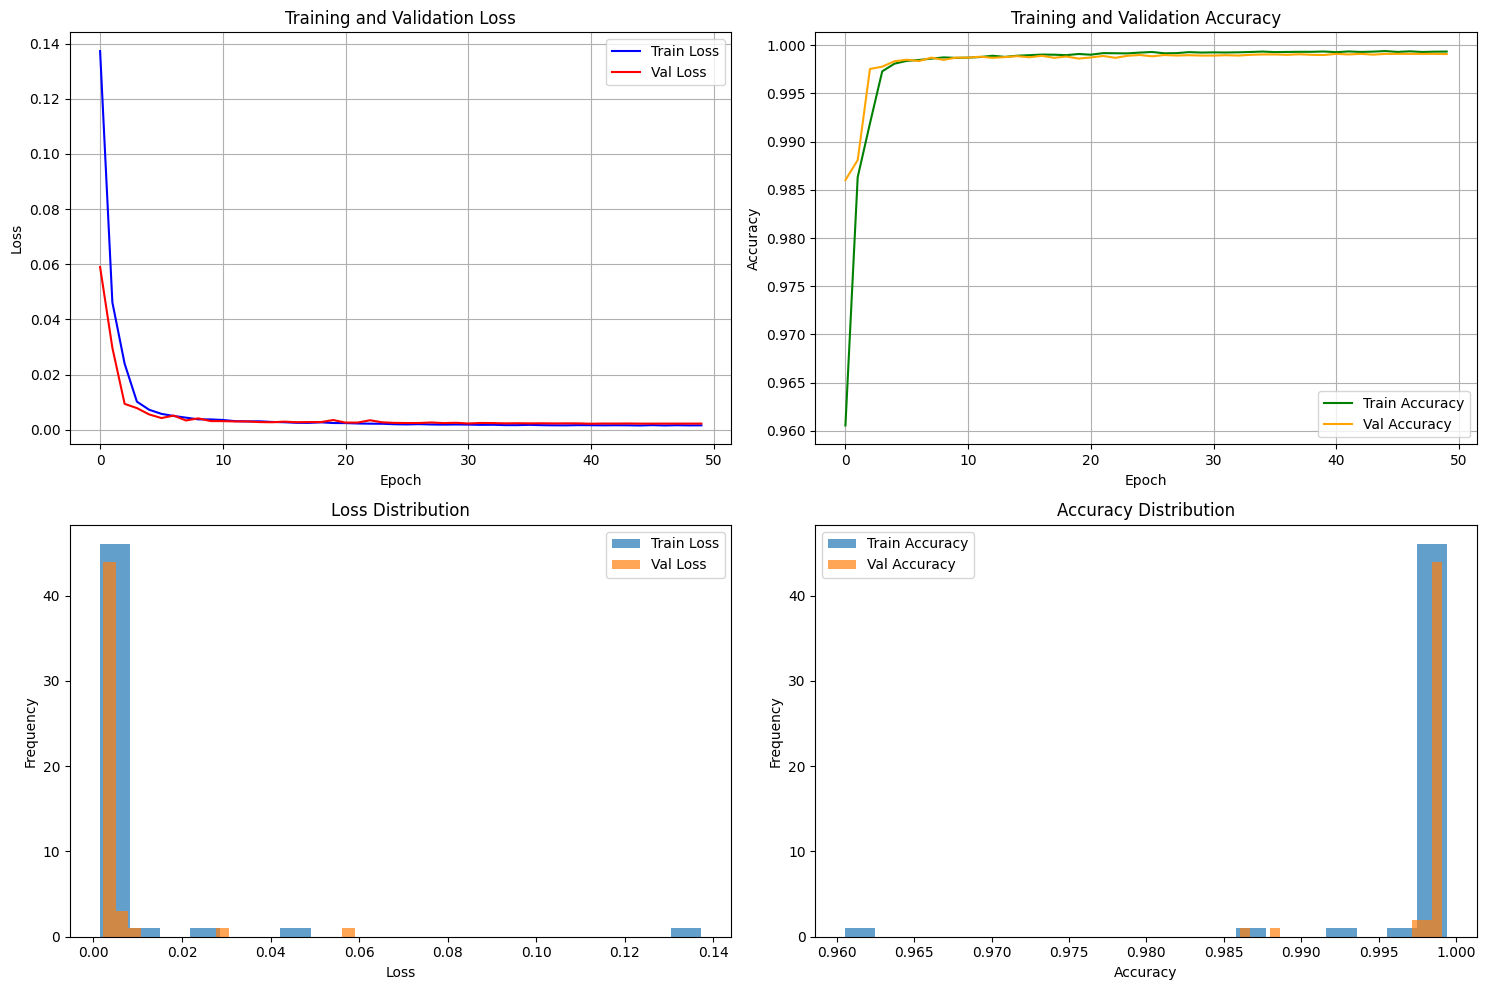

In [12]:
# Visualize training results
visualize_training(train_losses, val_losses, train_accs, val_accs)

In [13]:
# Test model performance
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
  for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      entropy_features = batch['entropy_features'].to(device)
      boundary_labels = batch['boundary_labels'].to(device)

      outputs = model(input_ids, entropy_features)
      predictions = torch.argmax(outputs['boundary_logits'], dim=-1)

      mask = boundary_labels != -1
      test_correct += (predictions == boundary_labels)[mask].sum().item()
      test_total += mask.sum().item()

      all_predictions.extend(predictions[mask].cpu().numpy())
      all_labels.extend(boundary_labels[mask].cpu().numpy())

test_accuracy = test_correct / test_total if test_total > 0 else 0
precision, recall, f1, _ = precision_recall_fscore_support(
  all_labels, all_predictions, average='weighted', zero_division=0
)

print(f"\nTest Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Test Results:
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F1 Score: 0.9993



Analyzing sample text: 'Machine learning is amazing. It can solve complex problems. Deep learning uses neural networks.'


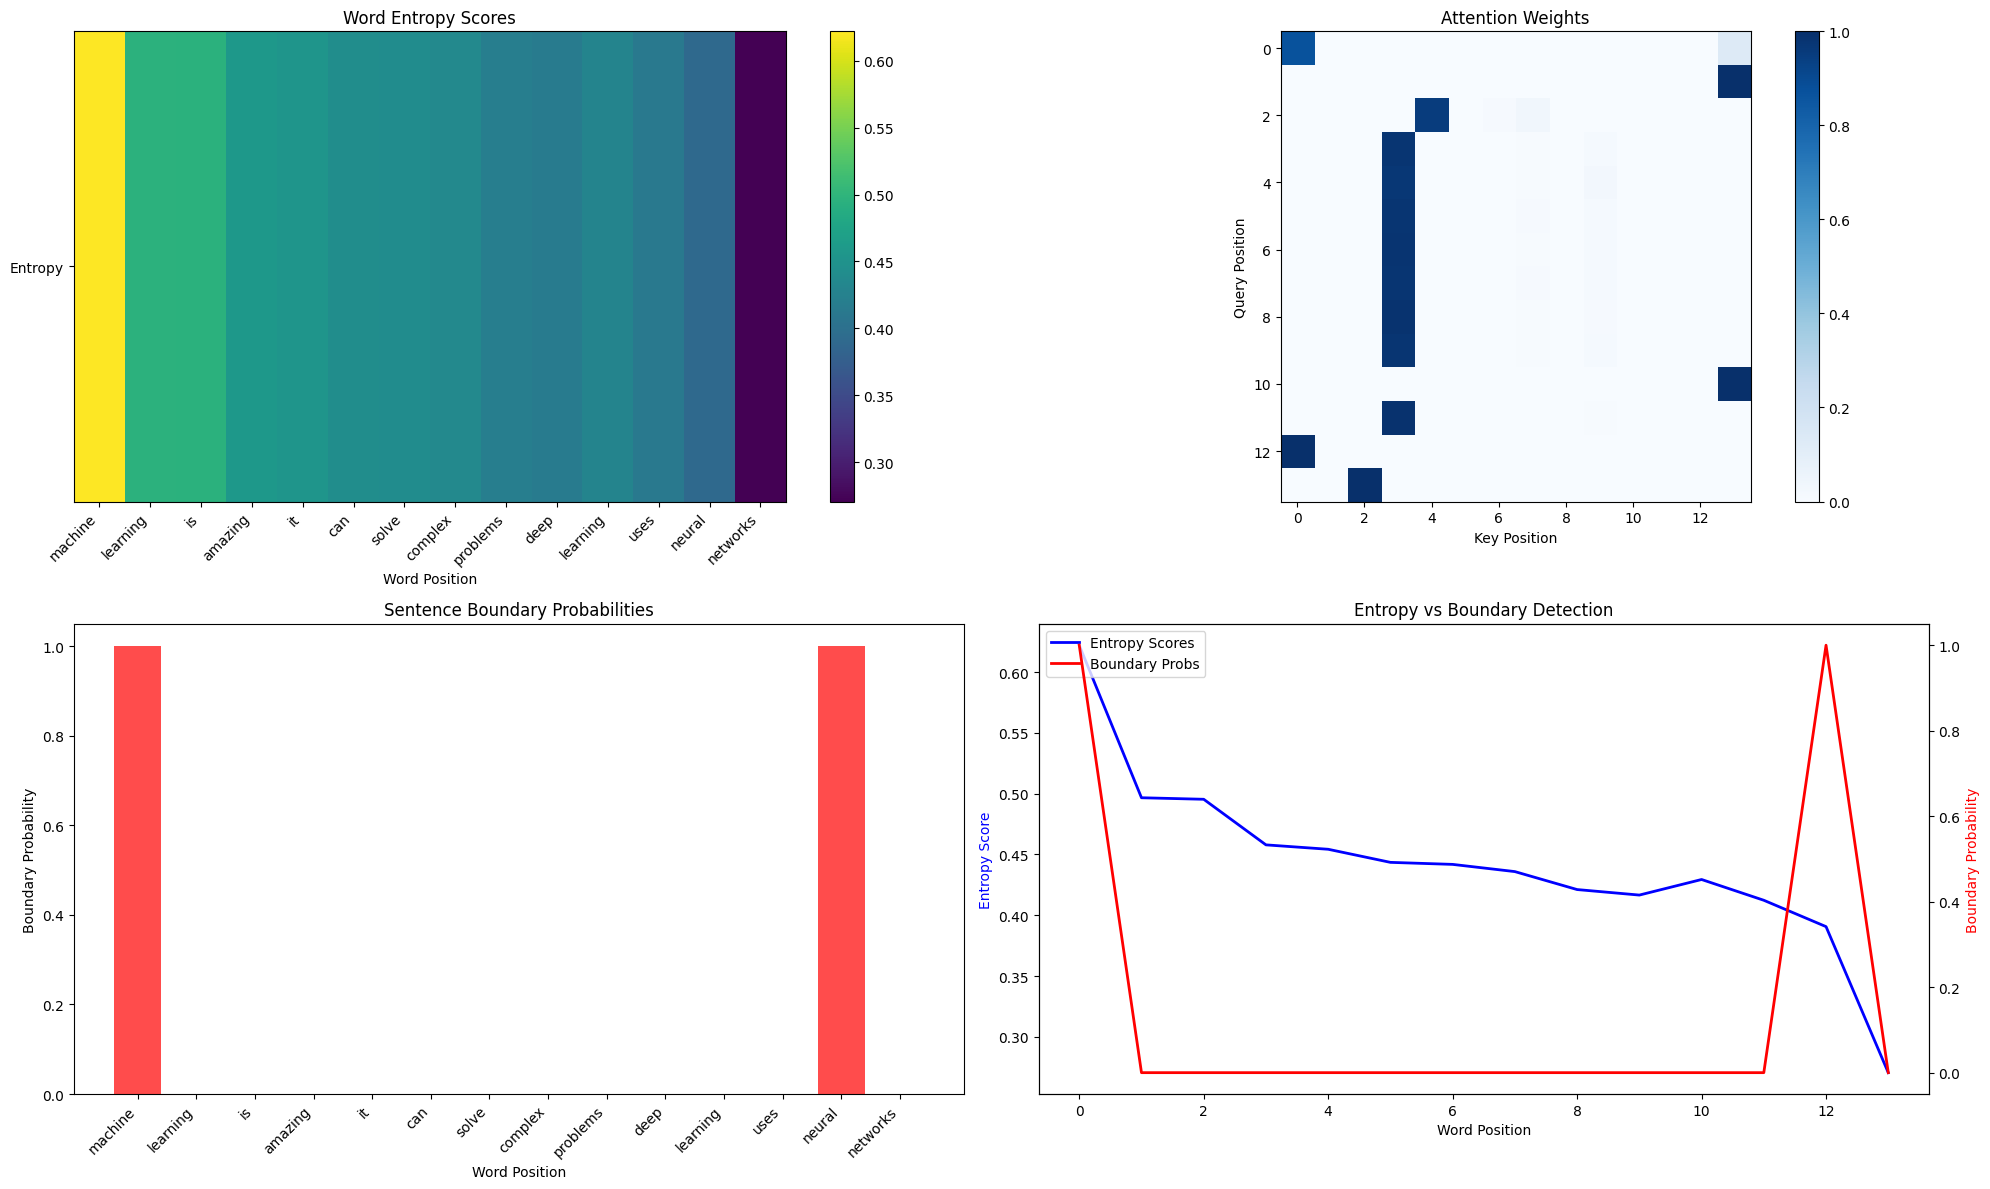


Predicting sentences for: 'artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions'
Predicted sentences:
1. Artificial intelligence is revolutionizing technology.
2. Machine learning algorithms process vast amounts of.
3. Data.
4. Neural networks mimic brain functions.


In [14]:
# Visualize entropy and attention for sample text
sample_text = "Machine learning is amazing. It can solve complex problems. Deep learning uses neural networks."
print(f"\nAnalyzing sample text: '{sample_text}'")

entropy_scores, boundary_probs = visualize_entropy_heatmap(
  model, sample_text, entropy_calc, entropy_calc.vocab
)

# Test sentence prediction
test_text = "artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions"
print(f"\nPredicting sentences for: '{test_text}'")

predicted_sentences, boundary_predictions = predict_sentences(
  model, test_text, entropy_calc, entropy_calc.vocab
)

print("Predicted sentences:")
for i, sentence in enumerate(predicted_sentences, 1):
  print(f"{i}. {sentence.capitalize()}.")

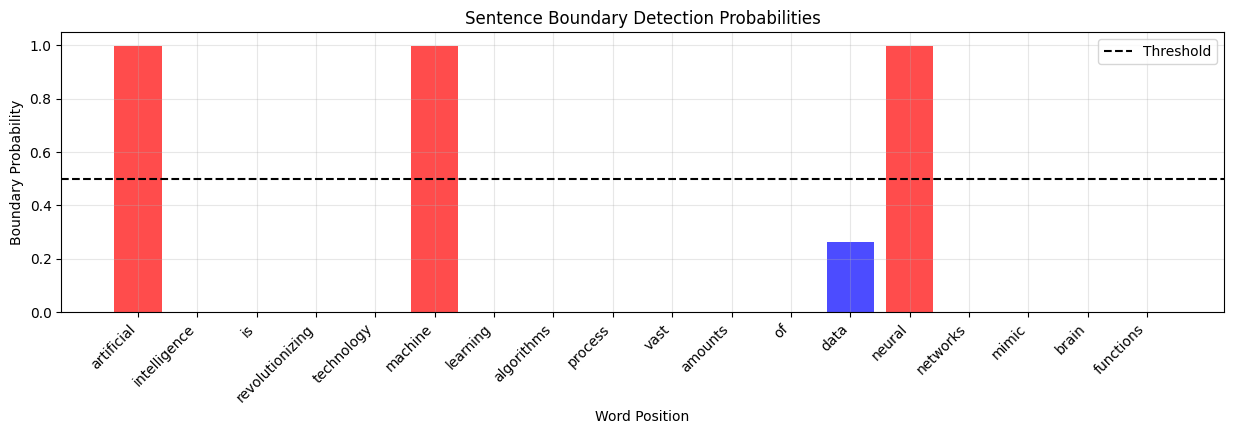

In [15]:
# Create boundary visualization
words = test_text.split()
plt.figure(figsize=(15, 8))

# Plot boundary probabilities
plt.subplot(2, 1, 1)
plt.bar(range(len(words)), boundary_predictions[:len(words)],
      color=['red' if p > 0.5 else 'blue' for p in boundary_predictions[:len(words)]],
      alpha=0.7)
plt.axhline(y=0.5, color='black', linestyle='--', label='Threshold')
plt.title('Sentence Boundary Detection Probabilities')
plt.xlabel('Word Position')
plt.ylabel('Boundary Probability')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

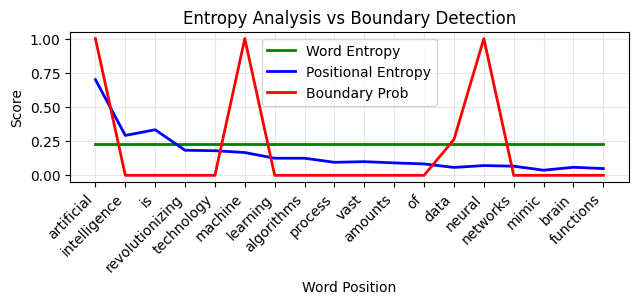

In [16]:
# Plot entropy analysis
plt.subplot(2, 1, 2)
word_entropy = entropy_calc.calculate_word_entropy(test_text)
pos_entropy = entropy_calc.calculate_positional_entropy(test_text)

plt.plot(word_entropy[:len(words)], 'g-', label='Word Entropy', linewidth=2)
plt.plot(pos_entropy[:len(words)], 'b-', label='Positional Entropy', linewidth=2)
plt.plot(boundary_predictions[:len(words)], 'r-', label='Boundary Prob', linewidth=2)

plt.title('Entropy Analysis vs Boundary Detection')
plt.xlabel('Word Position')
plt.ylabel('Score')
plt.xticks(range(len(words)), words, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

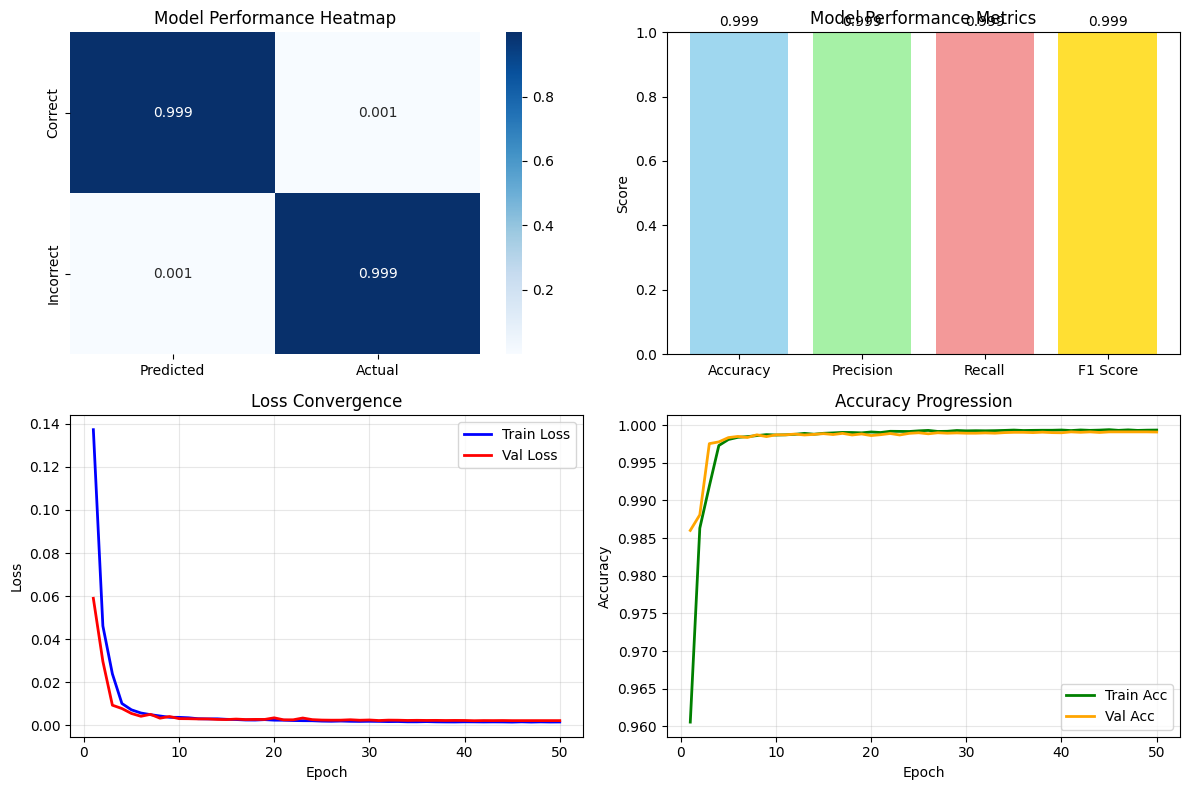

In [17]:
# Performance metrics visualization
plt.figure(figsize=(12, 8))

# Confusion matrix style visualization
plt.subplot(2, 2, 1)
confusion_data = np.array([[test_accuracy, 1-test_accuracy],
                        [1-test_accuracy, test_accuracy]])
sns.heatmap(confusion_data, annot=True, fmt='.3f', cmap='Blues',
          xticklabels=['Predicted', 'Actual'],
          yticklabels=['Correct', 'Incorrect'])
plt.title('Model Performance Heatmap')

# Metrics comparison
plt.subplot(2, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [test_accuracy, precision, recall, f1]
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, values):
  plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
          f'{value:.3f}', ha='center', va='bottom')

# Training progress
plt.subplot(2, 2, 3)
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
plt.title('Loss Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy progression
plt.subplot(2, 2, 4)
plt.plot(epochs, train_accs, 'g-', label='Train Acc', linewidth=2)
plt.plot(epochs, val_accs, 'orange', label='Val Acc', linewidth=2)
plt.title('Accuracy Progression')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Save model
torch.save({
  'model_state_dict': model.state_dict(),
  'vocab': entropy_calc.vocab,
  'entropy_calc': entropy_calc,
  'model_config': {
      'vocab_size': entropy_calc.vocab_size,
      'd_model': 256,
      'num_heads': 8,
      'num_layers': 6,
      'd_ff': 512,
      'max_seq_len': 512
  }
}, 'entropy_sentence_transformer.pth')

print("\nModel saved as 'entropy_sentence_transformer.pth'")


Model saved as 'entropy_sentence_transformer.pth'



Analyzing attention patterns...


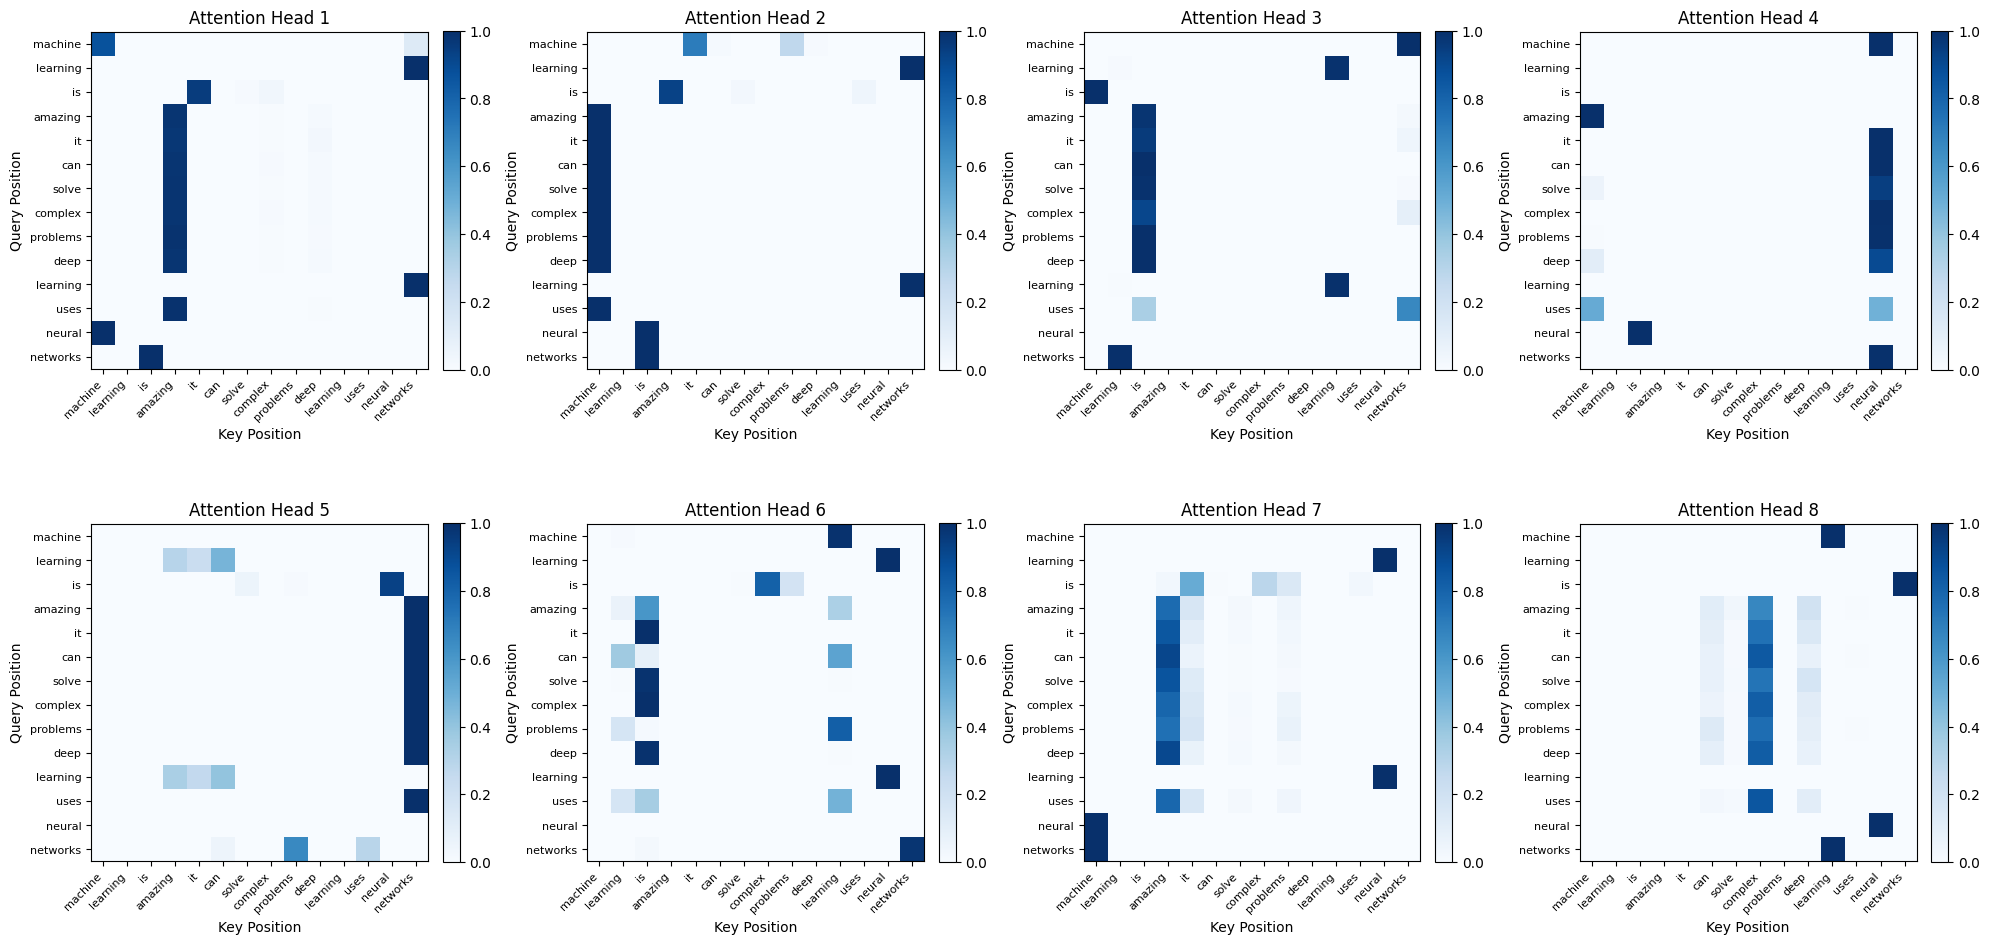

In [19]:
# Attention pattern visualization
def analyze_attention_patterns(model, text, entropy_calc, vocab):
  model.eval()
  clean_text = re.sub(r'[^\w\s]', '', text.lower())
  words = clean_text.split()[:20]  # Limit for clarity

  token_ids = [vocab.get(word, vocab['<UNK>']) for word in words]
  token_ids += [vocab['<PAD>']] * (512 - len(token_ids))

  word_entropy = entropy_calc.calculate_word_entropy(clean_text)
  pos_entropy = entropy_calc.calculate_positional_entropy(clean_text)

  entropy_features = []
  for i in range(len(words)):
      if i < len(word_entropy) and i < len(pos_entropy):
          contextual_entropy = len(set(words[max(0, i-2):min(len(words), i+3)])) / 5
          entropy_features.append([word_entropy[i], pos_entropy[i], contextual_entropy])
      else:
          entropy_features.append([0.0, 0.0, 0.0])

  while len(entropy_features) < 512:
      entropy_features.append([0.0, 0.0, 0.0])

  with torch.no_grad():
      input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
      entropy_features_tensor = torch.tensor([entropy_features], dtype=torch.float32).to(device)

      outputs = model(input_ids, entropy_features_tensor)
      attention_weights = outputs['attention_weights']

  # Visualize different attention heads
  fig, axes = plt.subplots(2, 4, figsize=(20, 10))
  axes = axes.flatten()

  for head in range(min(8, len(attention_weights[0][0]))):
      attn_matrix = attention_weights[0][0][head][:len(words), :len(words)].cpu().numpy()

      im = axes[head].imshow(attn_matrix, cmap='Blues')
      axes[head].set_title(f'Attention Head {head+1}')
      axes[head].set_xlabel('Key Position')
      axes[head].set_ylabel('Query Position')
      axes[head].set_xticks(range(len(words)))
      axes[head].set_yticks(range(len(words)))
      axes[head].set_xticklabels(words, rotation=45, ha='right', fontsize=8)
      axes[head].set_yticklabels(words, fontsize=8)

      plt.colorbar(im, ax=axes[head], fraction=0.046, pad=0.04)

  plt.tight_layout()
  plt.show()

# Analyze attention patterns
print("\nAnalyzing attention patterns...")
analyze_attention_patterns(model, sample_text, entropy_calc, entropy_calc.vocab)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import math
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class EntropyCalculator:
    def __init__(self):
        self.vocab = {}
        self.vocab_size = 0

    def build_vocab(self, texts):
        all_words = []
        for text in texts:
            words = text.lower().split()
            all_words.extend(words)

        word_counts = Counter(all_words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.vocab['<UNK>'] = len(self.vocab)
        self.vocab['<PAD>'] = len(self.vocab)
        self.vocab_size = len(self.vocab)

    def calculate_word_entropy(self, text):
        words = text.lower().split()
        word_counts = Counter(words)
        total_words = len(words)

        entropy_scores = []
        for word in words:
            prob = word_counts[word] / total_words
            entropy = -prob * math.log2(prob) if prob > 0 else 0
            entropy_scores.append(entropy)

        return entropy_scores

    def calculate_positional_entropy(self, text):
        words = text.lower().split()
        n = len(words)
        positional_entropy = []

        for i, word in enumerate(words):
            position_factor = 1.0 / (i + 1)  # Higher entropy at beginning
            char_entropy = len(set(word)) / len(word) if len(word) > 0 else 0
            pos_entropy = position_factor * char_entropy
            positional_entropy.append(pos_entropy)

        return positional_entropy

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(attn_output)

        return output, attention_weights

class EntropyEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Entropy-specific layers
        self.entropy_projection = nn.Linear(d_model, d_model)
        self.entropy_gate = nn.Linear(d_model * 2, d_model)

    def forward(self, x, entropy_features, mask=None):
        # Self-attention
        attn_output, attn_weights = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Entropy integration
        entropy_proj = self.entropy_projection(entropy_features)
        combined = torch.cat([x, entropy_proj], dim=-1)
        entropy_gate = torch.sigmoid(self.entropy_gate(combined))
        x = x * entropy_gate + entropy_proj * (1 - entropy_gate)

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights

class EntropyEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(max_seq_len, d_model))
        self.entropy_embedding = nn.Linear(3, d_model)  # word, positional, contextual entropy

        self.layers = nn.ModuleList([
            EntropyEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Entropy analysis heads
        self.entropy_head = nn.Linear(d_model, 1)
        self.boundary_head = nn.Linear(d_model, 2)  # boundary or not

    def forward(self, input_ids, entropy_features, mask=None):
        seq_len = input_ids.size(1)

        # Word embeddings + positional encoding
        x = self.embedding(input_ids) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:seq_len]
        x = self.dropout(x)

        # Entropy features embedding
        entropy_emb = self.entropy_embedding(entropy_features)

        attention_weights = []
        for layer in self.layers:
            x, attn_weights = layer(x, entropy_emb, mask)
            attention_weights.append(attn_weights)

        x = self.norm(x)

        # Calculate entropy scores and boundary predictions
        entropy_scores = self.entropy_head(x).squeeze(-1)
        boundary_logits = self.boundary_head(x)

        return {
            'hidden_states': x,
            'entropy_scores': entropy_scores,
            'boundary_logits': boundary_logits,
            'attention_weights': attention_weights
        }

class SentenceDecoder(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model, num_heads, d_ff, dropout, batch_first=True)
            for _ in range(num_layers)
        ])

        self.boundary_classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )

        self.confidence_head = nn.Linear(d_model, 1)

    def forward(self, encoder_output, mask=None):
        x = encoder_output['hidden_states']

        # Apply decoder layers (self-attention on encoded features)
        for layer in self.layers:
            x = layer(x, x)

        # Boundary classification
        boundary_logits = self.boundary_classifier(x)
        confidence_scores = torch.sigmoid(self.confidence_head(x))

        return {
            'boundary_logits': boundary_logits,
            'confidence_scores': confidence_scores,
            'final_hidden': x
        }

class ReinforcementLearner(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.value_network = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

        self.policy_network = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 2)  # boundary or not
        )

    def forward(self, hidden_states):
        values = self.value_network(hidden_states)
        policy_logits = self.policy_network(hidden_states)

        return values, policy_logits

class EntropySentenceTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=6,
                 d_ff=512, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.encoder = EntropyEncoder(vocab_size, d_model, num_heads, num_layers,
                                    d_ff, max_seq_len, dropout)
        self.decoder = SentenceDecoder(d_model, num_heads, num_layers//2, d_ff, dropout)
        self.rl_agent = ReinforcementLearner(d_model)

    def forward(self, input_ids, entropy_features, mask=None, use_rl=False):
        encoder_output = self.encoder(input_ids, entropy_features, mask)
        decoder_output = self.decoder(encoder_output, mask)

        if use_rl:
            values, policy_logits = self.rl_agent(encoder_output['hidden_states'])
            decoder_output['values'] = values
            decoder_output['policy_logits'] = policy_logits

        return {**encoder_output, **decoder_output}

def predict_sentences_from_text(input_text, model_path='entropy_sentence_transformer.pth', threshold=0.5, device=None):
    """
    Predict sentence boundaries from input text using the trained entropy-based transformer model.

    Args:
        input_text (str): The input text to segment into sentences
        model_path (str): Path to the saved model file
        threshold (float): Threshold for boundary detection (default: 0.5)
        device: PyTorch device (auto-detected if None)

    Returns:
        dict: Contains predicted sentences, boundary probabilities, and analysis
    """

    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    try:
        # Load the trained model and components with weights_only=False for custom classes
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        vocab = checkpoint['vocab']
        model_config = checkpoint['model_config']

        # Reconstruct the model
        model = EntropySentenceTransformer(**model_config)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()

        # Reconstruct entropy calculator
        entropy_calc = EntropyCalculator()
        entropy_calc.vocab = vocab
        entropy_calc.vocab_size = len(vocab)

        print(f"Model loaded successfully! Vocabulary size: {len(vocab)}")

    except FileNotFoundError:
        print(f"Model file '{model_path}' not found. Please train the model first.")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        print("\nTroubleshooting:")
        print("1. Make sure the model file exists")
        print("2. If you get a 'weights_only' error, the file loading has been updated to handle this")
        print("3. Ensure you have the correct PyTorch version")
        return None

    # Preprocess input text
    clean_text = re.sub(r'[^\w\s]', '', input_text.lower())
    words = clean_text.split()

    if not words:
        return {
            'original_text': input_text,
            'predicted_sentences': [],
            'boundary_probabilities': [],
            'message': 'No valid words found in input text'
        }

    print(f"Processing {len(words)} words...")

    # Process text in chunks if too long
    max_len = 512
    all_boundary_probs = []
    all_entropy_scores = []

    for i in range(0, len(words), max_len - 50):  # Overlap for context
        chunk_words = words[i:i + max_len - 2]
        chunk_text = ' '.join(chunk_words)

        # Prepare token IDs
        token_ids = [vocab.get(word, vocab['<UNK>']) for word in chunk_words]
        token_ids += [vocab['<PAD>']] * (max_len - len(token_ids))

        # Calculate entropy features
        word_entropy = entropy_calc.calculate_word_entropy(chunk_text)
        pos_entropy = entropy_calc.calculate_positional_entropy(chunk_text)

        entropy_features = []
        for j in range(len(chunk_words)):
            if j < len(word_entropy) and j < len(pos_entropy):
                # Calculate contextual entropy
                context_window = chunk_words[max(0, j-2):min(len(chunk_words), j+3)]
                contextual_entropy = len(set(context_window)) / len(context_window) if context_window else 0
                entropy_features.append([word_entropy[j], pos_entropy[j], contextual_entropy])
            else:
                entropy_features.append([0.0, 0.0, 0.0])

        # Pad entropy features
        while len(entropy_features) < max_len:
            entropy_features.append([0.0, 0.0, 0.0])

        # Forward pass through model
        with torch.no_grad():
            input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)
            entropy_features_tensor = torch.tensor([entropy_features], dtype=torch.float32).to(device)

            outputs = model(input_ids, entropy_features_tensor)

            # Get boundary probabilities
            boundary_logits = outputs['boundary_logits'][0][:len(chunk_words)]
            boundary_probs = F.softmax(boundary_logits, dim=-1)[:, 1].cpu().numpy()

            # Get entropy scores
            entropy_scores = outputs['entropy_scores'][0][:len(chunk_words)].cpu().numpy()

        all_boundary_probs.extend(boundary_probs)
        all_entropy_scores.extend(entropy_scores)

    # Trim to actual word count
    boundary_probs = all_boundary_probs[:len(words)]
    entropy_scores = all_entropy_scores[:len(words)]

    print("Model inference completed!")

    # Extract sentences based on threshold
    sentences = []
    current_sentence = []
    boundary_positions = []

    for i, (word, prob) in enumerate(zip(words, boundary_probs)):
        if prob > threshold and current_sentence:
            # End current sentence and start new one
            sentences.append(' '.join(current_sentence))
            boundary_positions.append(i)
            current_sentence = [word]
        else:
            current_sentence.append(word)

    # Add final sentence if exists
    if current_sentence:
        sentences.append(' '.join(current_sentence))

    # Calculate statistics
    avg_boundary_prob = sum(boundary_probs) / len(boundary_probs) if boundary_probs else 0
    avg_entropy = sum(entropy_scores) / len(entropy_scores) if entropy_scores else 0
    high_confidence_boundaries = sum(1 for p in boundary_probs if p > 0.8)

    # Format sentences with proper capitalization and punctuation
    formatted_sentences = []
    for sentence in sentences:
        if sentence.strip():
            formatted = sentence.strip().capitalize()
            if not formatted.endswith('.'):
                formatted += '.'
            formatted_sentences.append(formatted)

    return {
        'original_text': input_text,
        'predicted_sentences': formatted_sentences,
        'raw_sentences': sentences,
        'boundary_probabilities': boundary_probs,
        'entropy_scores': entropy_scores,
        'boundary_positions': boundary_positions,
        'word_list': words,
        'statistics': {
            'total_words': len(words),
            'predicted_sentences': len(formatted_sentences),
            'avg_boundary_probability': avg_boundary_prob,
            'avg_entropy_score': avg_entropy,
            'high_confidence_boundaries': high_confidence_boundaries,
            'threshold_used': threshold
        },
        'analysis': {
            'words_with_high_boundary_prob': [(words[i], boundary_probs[i])
                                            for i in range(len(words))
                                            if boundary_probs[i] > threshold],
            'entropy_summary': {
                'min_entropy': min(entropy_scores) if entropy_scores else 0,
                'max_entropy': max(entropy_scores) if entropy_scores else 0,
                'entropy_variance': sum((x - avg_entropy)**2 for x in entropy_scores) / len(entropy_scores) if entropy_scores else 0
            }
        }
    }

def visualize_predictions(result):
    """Visualize the sentence boundary predictions"""
    if not result:
        print("No results to visualize")
        return

    words = result['word_list']
    probs = result['boundary_probabilities']
    entropy_scores = result['entropy_scores']
    threshold = result['statistics']['threshold_used']

    # Limit visualization to first 30 words for clarity
    display_limit = min(30, len(words))

    plt.figure(figsize=(16, 10))

    # Plot 1: Boundary probabilities
    plt.subplot(3, 1, 1)
    colors = ['red' if p > threshold else 'blue' for p in probs[:display_limit]]
    bars = plt.bar(range(display_limit), probs[:display_limit], color=colors, alpha=0.7)

    plt.axhline(y=threshold, color='black', linestyle='--',
               label=f'Threshold ({threshold})')
    plt.title('Sentence Boundary Detection Probabilities', fontsize=14, fontweight='bold')
    plt.xlabel('Word Position')
    plt.ylabel('Boundary Probability')
    plt.xticks(range(display_limit), words[:display_limit], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Entropy scores
    plt.subplot(3, 1, 2)
    plt.plot(range(display_limit), entropy_scores[:display_limit], 'g-',
            label='Entropy Scores', linewidth=2, marker='o', markersize=4)
    plt.title('Word Entropy Scores', fontsize=14, fontweight='bold')
    plt.xlabel('Word Position')
    plt.ylabel('Entropy Score')
    plt.xticks(range(display_limit), words[:display_limit], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 3: Combined view
    plt.subplot(3, 1, 3)
    # Normalize entropy scores for better comparison
    norm_entropy = [(e - min(entropy_scores[:display_limit])) /
                   (max(entropy_scores[:display_limit]) - min(entropy_scores[:display_limit]) + 1e-8)
                   for e in entropy_scores[:display_limit]]

    plt.plot(range(display_limit), norm_entropy, 'g-',
            label='Normalized Entropy', linewidth=2, marker='o', markersize=4)
    plt.plot(range(display_limit), probs[:display_limit], 'r-',
            label='Boundary Probabilities', linewidth=2, marker='s', markersize=4)

    plt.axhline(y=threshold, color='black', linestyle='--', alpha=0.7,
               label=f'Threshold ({threshold})')

    plt.title('Entropy vs Boundary Detection (Combined View)', fontsize=14, fontweight='bold')
    plt.xlabel('Word Position')
    plt.ylabel('Normalized Score')
    plt.xticks(range(display_limit), words[:display_limit], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Entropy-based Sentence Boundary Predictor
Test input: artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

Model loaded successfully! Vocabulary size: 603
Processing 29 words...
Model inference completed!

ORIGINAL TEXT:
artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

PREDICTED SENTENCES (5):
1. Artificial intelligence is revolutionizing technology.
2. Machine learning algorithms process vast amounts of.
3. Data.
4. Neural networks mimic brain functions transformers changed natural.
5. Language processing deep learning requires significant computational resources.

Generating vi

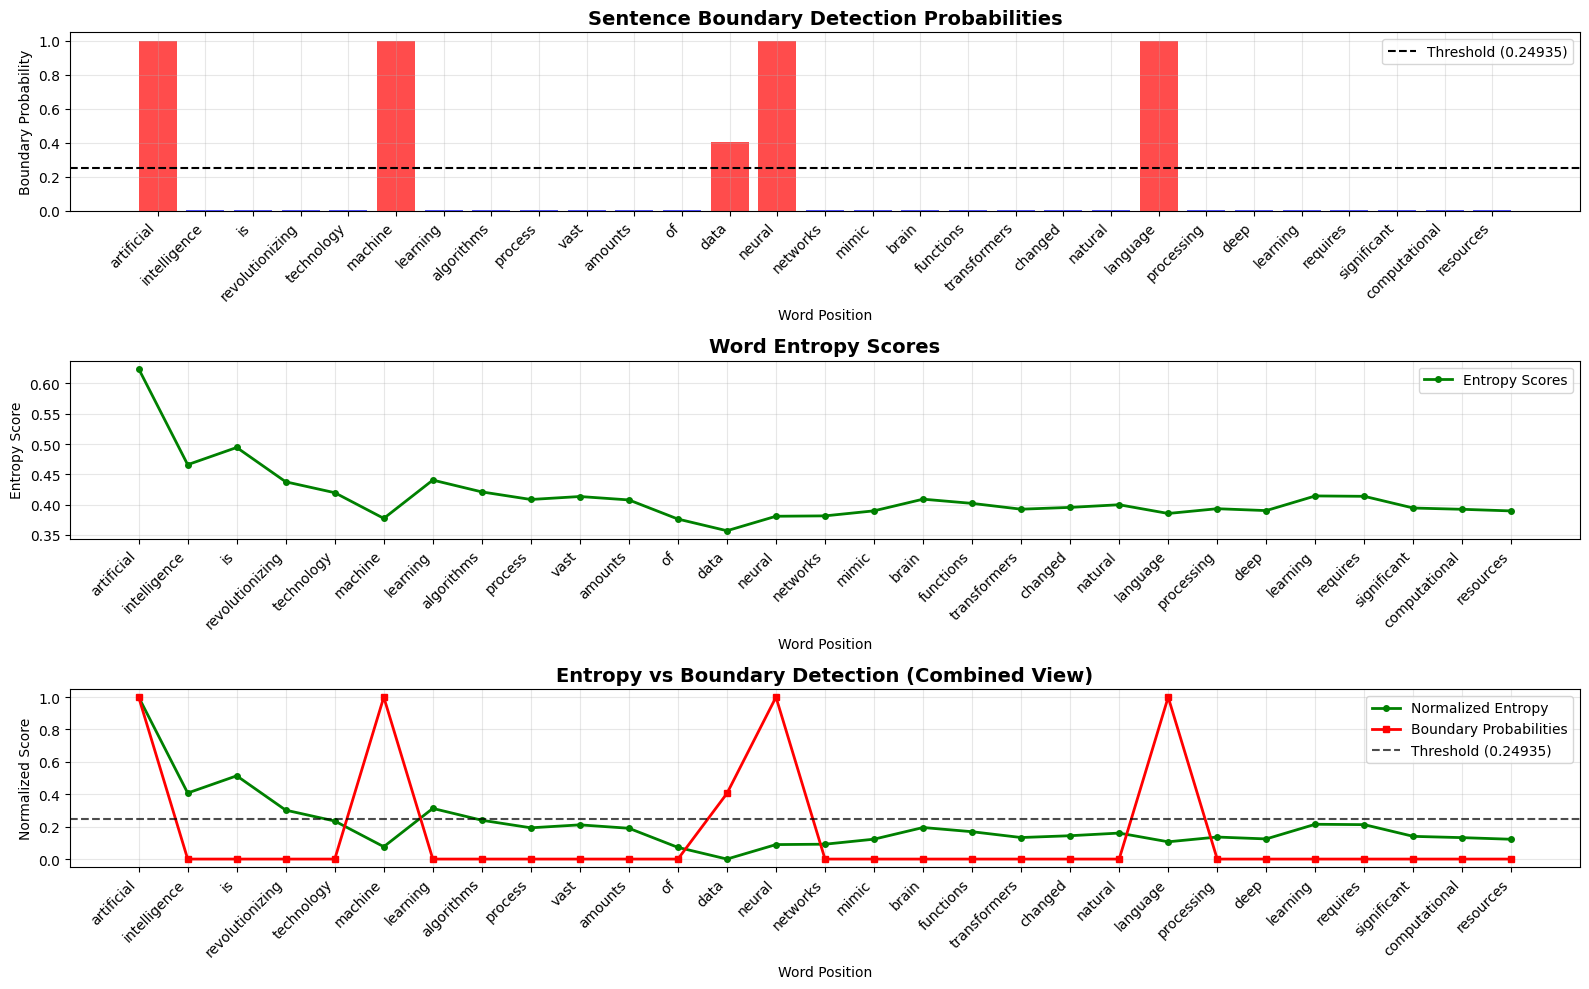

In [21]:
print("Entropy-based Sentence Boundary Predictor")
print("="*50)

# Test with sample text
test_text = """artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources"""

print(f"Test input: {test_text}")
print("\n" + "="*50)

# Make prediction
result = predict_sentences_from_text(test_text, threshold=0.24935)

if result:
    print(f"\nORIGINAL TEXT:")
    print(f"{result['original_text']}")
    print(f"\nPREDICTED SENTENCES ({len(result['predicted_sentences'])}):")
    for i, sentence in enumerate(result['predicted_sentences'], 1):
        print(f"{i}. {sentence}")

    # print(f"\nDETAILED STATISTICS:")
    # stats = result['statistics']
    # print(f"📊 Total words processed: {stats['total_words']}")
    # print(f"📝 Sentences detected: {stats['predicted_sentences']}")
    # print(f"📈 Average boundary probability: {stats['avg_boundary_probability']:.3f}")
    # print(f"🧠 Average entropy score: {stats['avg_entropy_score']:.3f}")
    # print(f"🎯 High confidence boundaries: {stats['high_confidence_boundaries']}")
    # print(f"⚖️  Threshold used: {stats['threshold_used']}")

    # print(f"\nBOUNDARY ANALYSIS:")
    # print("Words with high boundary probability:")
    # for word, prob in result['analysis']['words_with_high_boundary_prob'][:10]:
    #     print(f"  • '{word}': {prob:.3f}")

    # print(f"\nENTROPY ANALYSIS:")
    # entropy_info = result['analysis']['entropy_summary']
    # print(f"  • Min entropy: {entropy_info['min_entropy']:.3f}")
    # print(f"  • Max entropy: {entropy_info['max_entropy']:.3f}")
    # print(f"  • Entropy variance: {entropy_info['entropy_variance']:.3f}")

    # Visualize results
    print(f"\nGenerating visualization...")
    visualize_predictions(result)

else:
    print("❌ Failed to process text. Please check:")
    print("1. Model file 'entropy_sentence_transformer.pth' exists")
    print("2. Model was trained and saved properly")
    print("3. All dependencies are installed")

Entropy-based Sentence Boundary Predictor
Test input: artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

Model loaded successfully! Vocabulary size: 603
Processing 29 words...
Model inference completed!

📌 INITIAL RUN

ORIGINAL TEXT:
artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

PREDICTED SENTENCES (5):
1. Artificial intelligence is revolutionizing technology.
2. Machine learning algorithms process vast amounts of.
3. Data.
4. Neural networks mimic brain functions transformers changed natural.
5. Language processing deep learning requires significant computational resources.

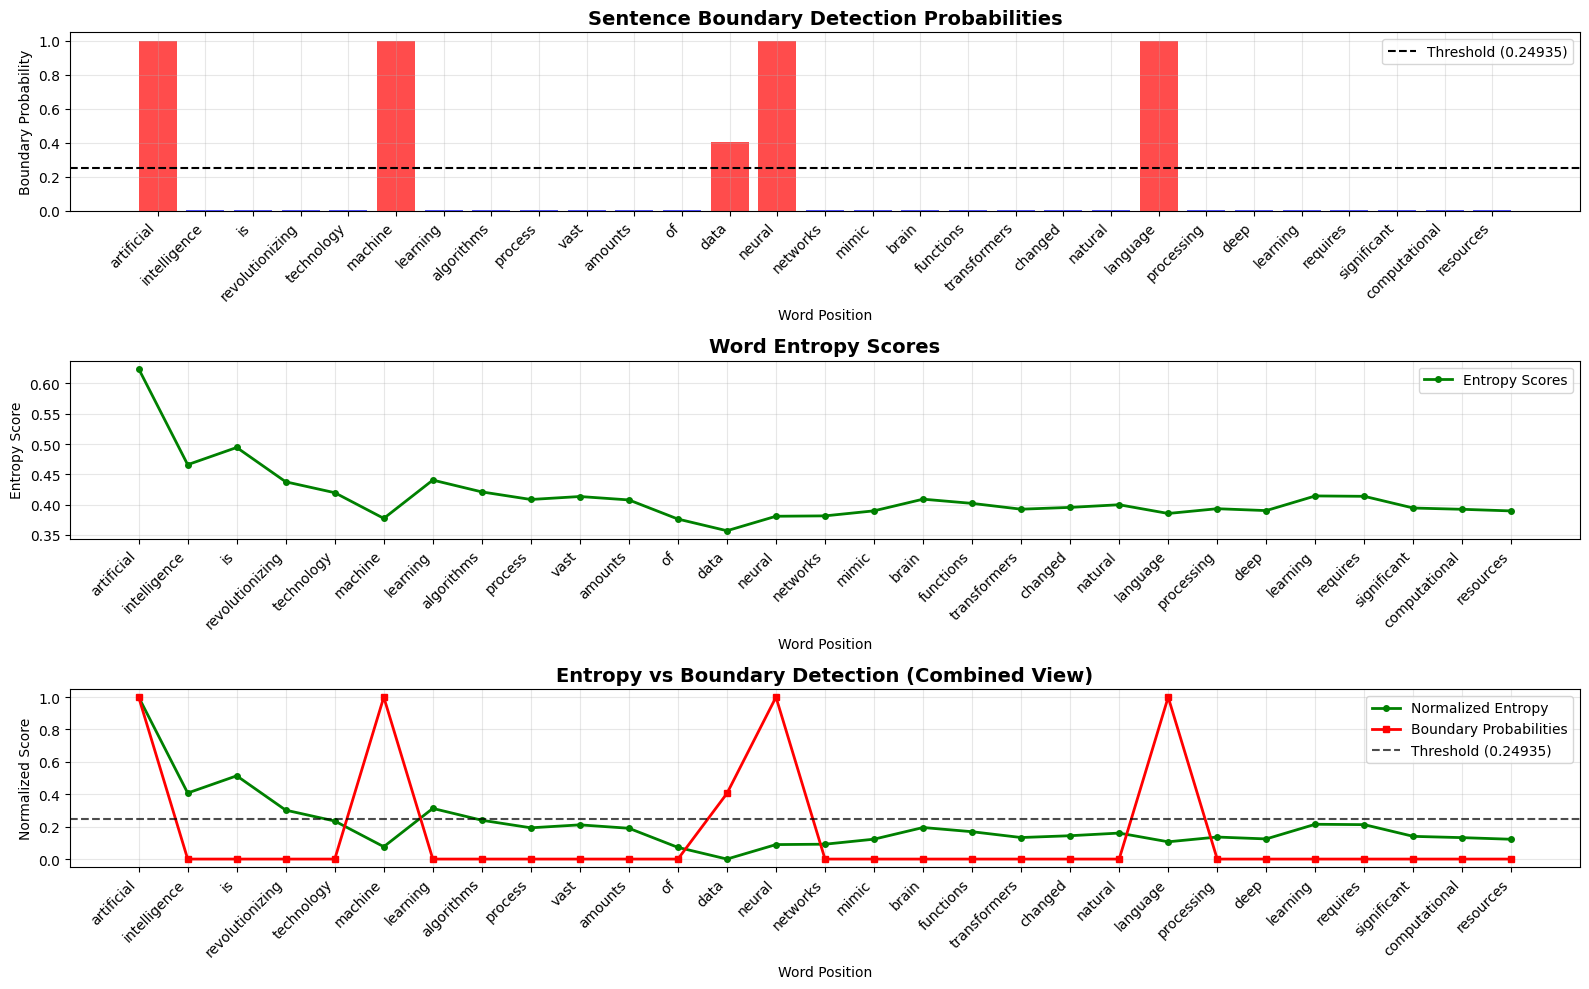


🔁 RECALCULATED THRESHOLD
• Formula: T = μ + k * √σ²
• μ = 0.151887
• σ² = 0.002340
• k = 0.06
• ⇒ New Threshold = 0.154790
Model loaded successfully! Vocabulary size: 603
Processing 29 words...
Model inference completed!

✅ SECOND RUN WITH RECALCULATED THRESHOLD

PREDICTED SENTENCES (5):
1. Artificial intelligence is revolutionizing technology.
2. Machine learning algorithms process vast amounts of.
3. Data.
4. Neural networks mimic brain functions transformers changed natural.
5. Language processing deep learning requires significant computational resources.

📈 Generating visualization for updated prediction...


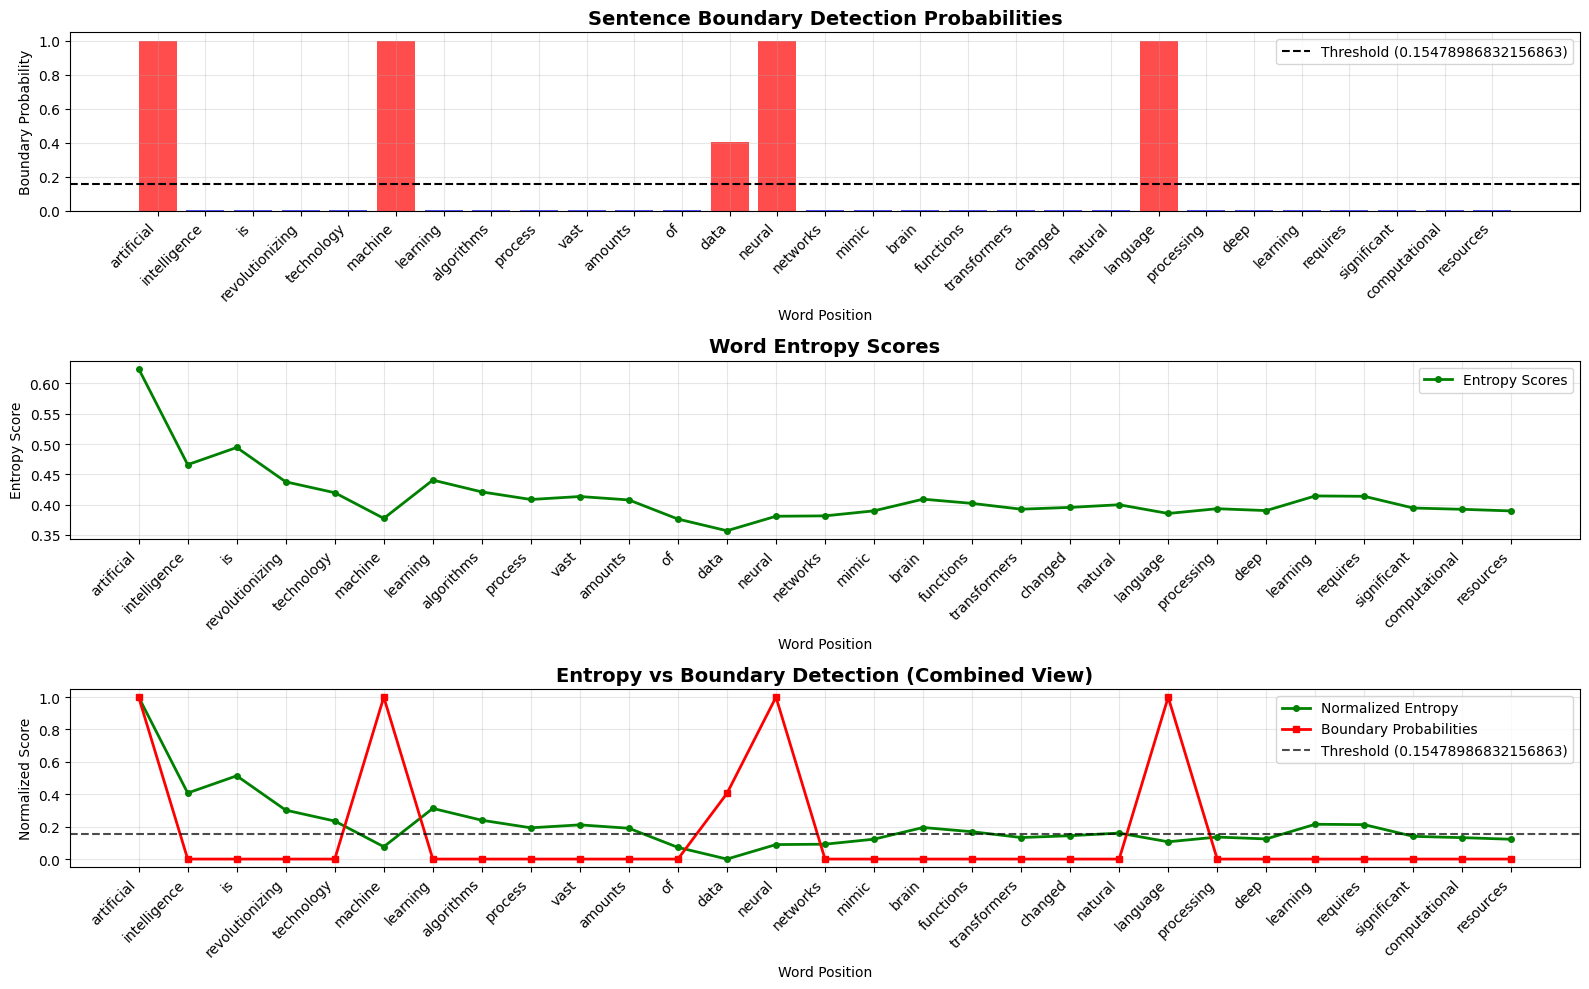

In [22]:
import math

print("Entropy-based Sentence Boundary Predictor")
print("="*50)

# Test with sample text
test_text = """artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources"""

print(f"Test input: {test_text}")
print("\n" + "="*50)

# Step 1: Initial prediction
initial_threshold = 0.2485
result_initial = predict_sentences_from_text(test_text, threshold=initial_threshold)

if result_initial:
    print(f"\n📌 INITIAL RUN")
    print(f"\nORIGINAL TEXT:\n{result_initial['original_text']}")
    print(f"\nPREDICTED SENTENCES ({len(result_initial['predicted_sentences'])}):")
    for i, sentence in enumerate(result_initial['predicted_sentences'], 1):
        print(f"{i}. {sentence}")

    # Show initial stats
    stats = result_initial['statistics']
    print(f"\n📊 INITIAL STATISTICS:")
    print(f"• Total words: {stats['total_words']}")
    print(f"• Sentences detected: {stats['predicted_sentences']}")
    print(f"• Avg boundary probability: {stats['avg_boundary_probability']:.6f}")
    print(f"• Avg entropy score: {stats['avg_entropy_score']:.6f}")
    print(f"• Threshold used: {stats['threshold_used']}")
    print(f"• High confidence boundaries: {stats['high_confidence_boundaries']}")
    
    # Visualization
    print(f"\n📈 Generating visualization for updated prediction...")
    visualize_predictions(result)

    # Step 2: Recalculate threshold using formula
    avg_boundary_prob = stats['avg_boundary_probability']
    entropy_variance = result_initial['analysis']['entropy_summary']['entropy_variance']
    k = 0.06  # tuning factor

    dynamic_threshold = avg_boundary_prob + k * math.sqrt(entropy_variance)

    print(f"\n🔁 RECALCULATED THRESHOLD")
    print(f"• Formula: T = μ + k * √σ²")
    print(f"• μ = {avg_boundary_prob:.6f}")
    print(f"• σ² = {entropy_variance:.6f}")
    print(f"• k = {k}")
    print(f"• ⇒ New Threshold = {dynamic_threshold:.6f}")

    # Step 3: Re-run with new threshold
    result_updated = predict_sentences_from_text(test_text, threshold=dynamic_threshold)

    print(f"\n✅ SECOND RUN WITH RECALCULATED THRESHOLD")
    print(f"\nPREDICTED SENTENCES ({len(result_updated['predicted_sentences'])}):")
    for i, sentence in enumerate(result_updated['predicted_sentences'], 1):
        print(f"{i}. {sentence}")

    # Optional visualization
    print(f"\n📈 Generating visualization for updated prediction...")
    visualize_predictions(result_updated)

else:
    print("❌ Failed to process text. Please check:")
    print("1. Model file 'entropy_sentence_transformer.pth' exists")
    print("2. Model was trained and saved properly")
    print("3. All dependencies are installed")


Entropy-based Sentence Boundary Predictor
Test input: artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

Model loaded successfully! Vocabulary size: 603
Processing 29 words...
Model inference completed!

📌 INITIAL RUN

ORIGINAL TEXT:
artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources

PREDICTED SENTENCES (5):
1. Artificial intelligence is revolutionizing technology.
2. Machine learning algorithms process vast amounts of.
3. Data.
4. Neural networks mimic brain functions transformers changed natural.
5. Language processing deep learning requires significant computational resources.

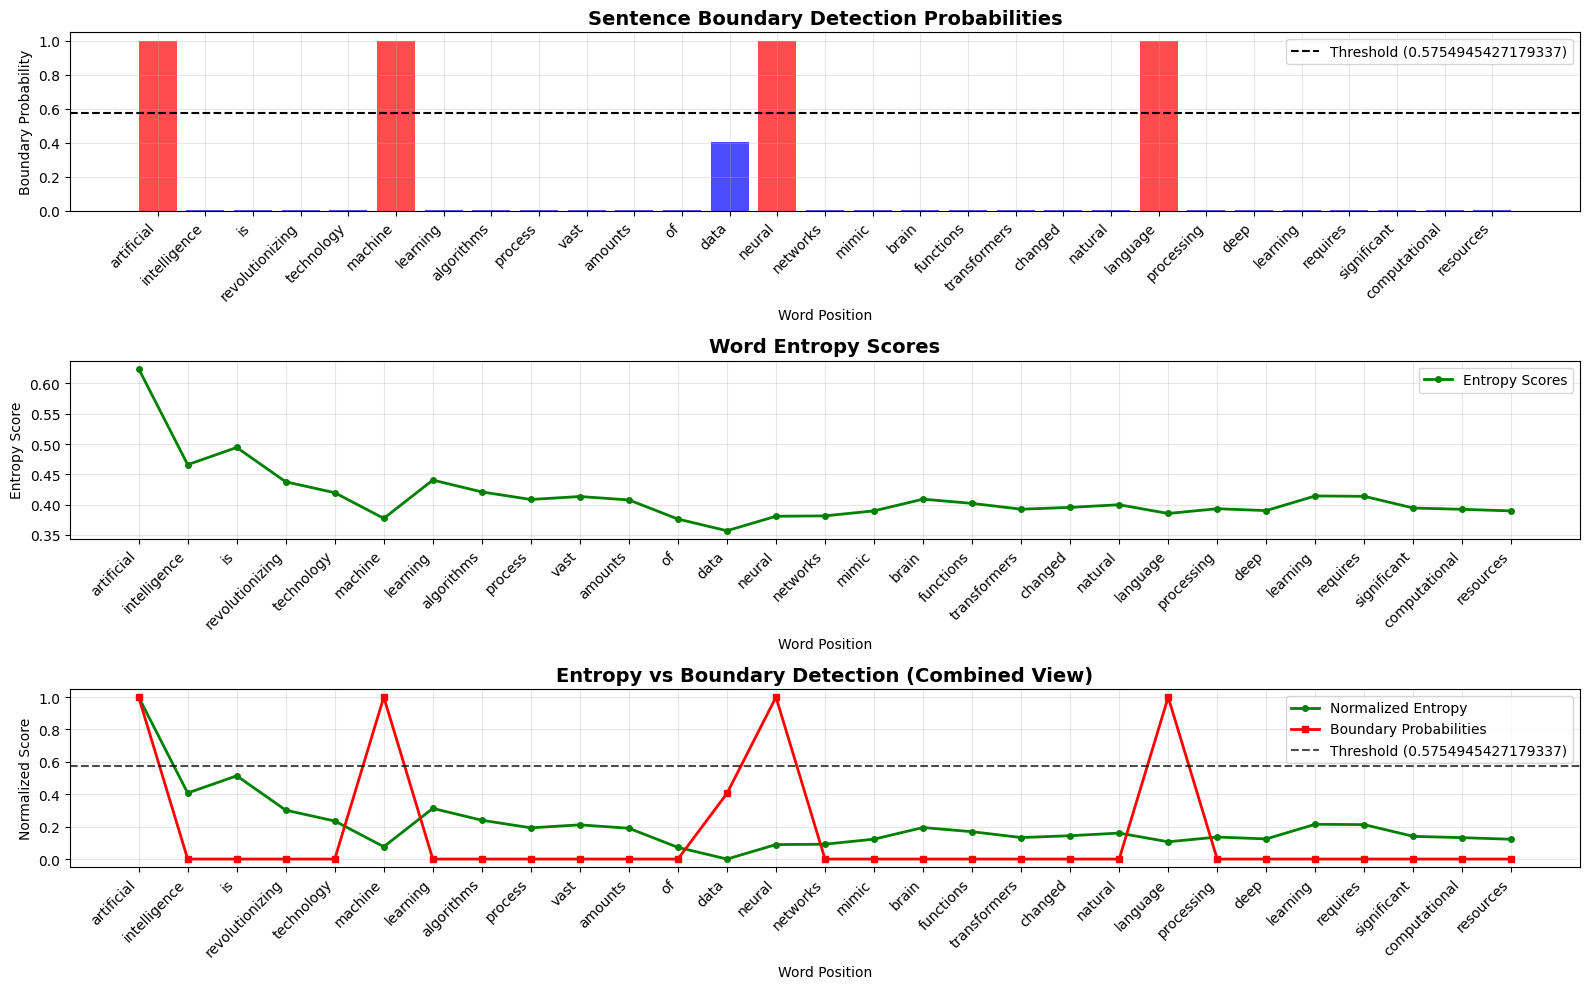

In [23]:
import math
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print("Entropy-based Sentence Boundary Predictor")
print("="*50)

# Test input
test_text = """artificial intelligence is revolutionizing technology machine learning algorithms process vast amounts of data neural networks mimic brain functions transformers changed natural language processing deep learning requires significant computational resources"""

print(f"Test input: {test_text}")
print("\n" + "="*50)

# Step 1: Initial prediction
initial_threshold = 0.2485
result_initial = predict_sentences_from_text(test_text, threshold=initial_threshold)

if result_initial:
    print(f"\n📌 INITIAL RUN")
    print(f"\nORIGINAL TEXT:\n{result_initial['original_text']}")
    print(f"\nPREDICTED SENTENCES ({len(result_initial['predicted_sentences'])}):")
    for i, sentence in enumerate(result_initial['predicted_sentences'], 1):
        print(f"{i}. {sentence}")

    # Extract raw boundary probabilities
    raw_boundary_probs = np.array(result_initial['boundary_probabilities'])

    # Step 2: Normalize with sigmoid
    norm_boundary_probs = sigmoid(raw_boundary_probs)

    # Step 3: Compute dynamic threshold on normalized values
    avg_norm_prob = np.mean(norm_boundary_probs)
    std_norm_prob = np.std(norm_boundary_probs)
    k = 0.5  # tuning factor, you can adjust

    dynamic_threshold = avg_norm_prob + k * std_norm_prob

    print(f"\n🔁 RECALCULATED THRESHOLD (with sigmoid normalization)")
    print(f"• Normalized Avg Boundary Prob (μ): {avg_norm_prob:.6f}")
    print(f"• Std Dev (σ): {std_norm_prob:.6f}")
    print(f"• Formula: T = μ + k * σ")
    print(f"• k = {k}")
    print(f"• ⇒ New Threshold = {dynamic_threshold:.6f}")

    # Step 4: Re-run with updated threshold
    result_updated = predict_sentences_from_text(test_text, threshold=dynamic_threshold)

    print(f"\n✅ SECOND RUN WITH NORMALIZED THRESHOLD")
    print(f"\nPREDICTED SENTENCES ({len(result_updated['predicted_sentences'])}):")
    for i, sentence in enumerate(result_updated['predicted_sentences'], 1):
        print(f"{i}. {sentence}")

    # Step 5: Visualize updated result
    print(f"\n📈 Generating visualization for updated prediction...")
    visualize_predictions(result_updated)

else:
    print("❌ Failed to process text. Please check:")
    print("1. Model file 'entropy_sentence_transformer.pth' exists")
    print("2. Model was trained and saved properly")
    print("3. All dependencies are installed")
